In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from types import SimpleNamespace
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import wavfile
from scipy.signal import correlate
from scipy import signal as sg
import time
import scipy
from matplotlib import pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data/pitch/test"))

# Any results you write to the current directory are saved as output.

['F5.wav', 'F4.wav', 'F3.wav', 'F2.wav', 'F1.wav', 'M1.wav', 'M2.wav', 'M3.wav', 'M4.wav', 'M5.wav']


In [60]:
class Counters:
    def __init__(self, gross_threshold=0.2):
        self.num_voiced = 0
        self.num_unvoiced = 0
        self.num_voiced_unvoiced = 0
        self.num_unvoiced_voiced = 0
        self.num_voiced_voiced = 0
        self.num_gross_errors = 0
        self.fine_error = 0
        self.e2 = 0
        self.gross_threshold = gross_threshold
        self.nfiles = 0

    def add(self, other):
        if other is not None:
            self.num_voiced += other.num_voiced
            self.num_unvoiced += other.num_unvoiced
            self.num_voiced_unvoiced += other.num_voiced_unvoiced
            self.num_unvoiced_voiced += other.num_unvoiced_voiced
            self.num_voiced_voiced += other.num_voiced_voiced
            self.num_gross_errors += other.num_gross_errors
            self.fine_error += other.fine_error
            self.e2 += other.e2
            self.nfiles += 1

    def __repr__(self):
        nframes = self.num_voiced + self.num_unvoiced
        if self.nfiles > 0:
            self.fine_error /= self.nfiles
        str = [
            f"Num. frames:\t{self.num_unvoiced + self.num_voiced} = {self.num_unvoiced} unvoiced + {self.num_voiced} voiced",
            f"Unvoiced frames as voiced:\t{self.num_unvoiced_voiced}/{self.num_unvoiced} ({100*self.num_unvoiced_voiced/self.num_unvoiced:.2f}%)",
            f"Voiced frames as unvoiced:\t{self.num_voiced_unvoiced}/{self.num_voiced} ({100*self.num_voiced_unvoiced/self.num_voiced:.2f}%)",
            f"Gross voiced errors (>{100*self.gross_threshold}%):\t{self.num_gross_errors}/{self.num_voiced_voiced} ({100*self.num_gross_errors/self.num_voiced_voiced:.2f}%)",
            f"MSE of fine errors:\t{100*self.fine_error:.2f}%",
            f"RMSE:\t{np.sqrt(self.e2/nframes):.2f}"
        ]
        return '\n'.join(str)

In [61]:
def compare(fref, pitch):
    vref = np.loadtxt(fref)
    vtest = np.array(pitch)

    diff_frames = len(vref) - len(vtest)
    if abs(diff_frames) > 5:
        print(f"Error: number of frames in ref ({len(vref)}) != number of frames in test ({len(vtest)})")
        return None
    elif diff_frames > 0:
        vref = np.resize(vref, vtest.shape)
    elif diff_frames < 0:
        vtest = np.resize(vtest, vref.shape)

    counters = Counters()
    counters.num_voiced = np.count_nonzero(vref)
    counters.num_unvoiced = len(vref) - counters.num_voiced
    counters.num_unvoiced_voiced = np.count_nonzero(np.logical_and(vref == 0, vtest != 0))
    counters.num_voiced_unvoiced = np.count_nonzero(np.logical_and(vref != 0, vtest == 0))

    voiced_voiced = np.logical_and(vref != 0, vtest != 0)
    counters.num_voiced_voiced = np.count_nonzero(voiced_voiced)

    f = np.absolute(vref[voiced_voiced] - vtest[voiced_voiced])/vref[voiced_voiced]
    gross_errors = f > counters.gross_threshold
    counters.num_gross_errors = np.count_nonzero(gross_errors)
    fine_errors = np.logical_not(gross_errors)
    counters.fine_error = np.sqrt(np.square(f[fine_errors]).mean())
    counters.e2 = np.square(vref - vtest).sum()

    return counters

In [80]:
def cepstrum_method(frame, sfreq, fmin=40, fmax=400, verbose=False):
    """Estimate pitch using autocorrelation
    """
    # Preprocessing options
    windowing = False
    smoothing_gaussian = False
    smoothing_savgol_filter = True
    
    
    # plot frame
    if verbose:
        plt.figure()
        plt.title('Frame')
        plt.plot(frame)
        plt.xlabel('Frame Samples')
        plt.show
        
    if windowing:
        window = sg.windows.hann(len(frame))
        frame = frame*window
        
        if verbose:
            plt.figure()
            plt.title('Windowed Frame')
            plt.plot(frame)
            plt.xlabel('Windowed Frame Samples')
            plt.show
        
    if smoothing_gaussian:
        std = 0.5
        frame = scipy.ndimage.gaussian_filter1d(frame, std)

        if verbose:
            plt.figure()
            plt.title('Smoothed Frame')
            plt.plot(frame)
            plt.xlabel('Smoothed Frame Samples')
            plt.show
    
    if smoothing_savgol_filter:
        window_lenght = 15
        order = 2
        frame = sg.savgol_filter(frame, window_lenght, order)

        if verbose:
            plt.figure()
            plt.title('Smoothed Frame 2')
            plt.plot(frame)
            plt.xlabel('Smoothed Frame 2 Samples')
            plt.show

    spectrum = np.fft.fft(frame)
    
    # plot spectrum
    if verbose:
        plt.figure()
        plt.title('Spectrum')
        plt.plot(spectrum)
        plt.xlabel('Spectrum Samples')
        plt.show
    
    cepstrum = np.fft.ifft(np.log(np.abs(spectrum))).real
    
    # plot spectrum
    if verbose:
        plt.figure()
        plt.title('Ceptrum')
        plt.plot(cepstrum)
        plt.xlabel('Cepstrum Samples')
        plt.yscale('log')
        plt.show

    f0 = 1
    if f0 >= fmin and f0 <= fmax:
        return f0
    else:
        return 0

In [78]:
def wav2f0_file(options, filename):
    totalCounters = Counters() 
    sfreq, data = wavfile.read(filename)
    nsamples = len(data)
    # From miliseconds to samples
    ns_windowlength = int(round((options.windowlength * sfreq) / 1000))
    ns_frameshift = int(round((options.frameshift * sfreq) / 1000))
    ns_left_padding = int(round((options.left_padding * sfreq) / 1000))
    ns_right_padding = int(round((options.right_padding * sfreq) / 1000))
    pitch = []
    for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
        if id > 10: break 
        first_sample = max(0, ini)
        last_sample = min(nsamples, ini + ns_windowlength)
        frame = data[first_sample:last_sample]
        f0 = cepstrum_method(frame, sfreq, verbose=True)
        pitch.append(f0)
        
    # Apply median filter to pitch array
    # pitch = sg.medfilt(volume=pitch, kernel_size=3)

/Users/oscarortigonzalez/.local/share/virtualenvs/pitch-estimation-notebooks-8M_mJogl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/oscarortigonzalez/.local/share/virtualenvs/pitch-estimation-notebooks-8M_mJogl/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Required time: 0.6528358459472656


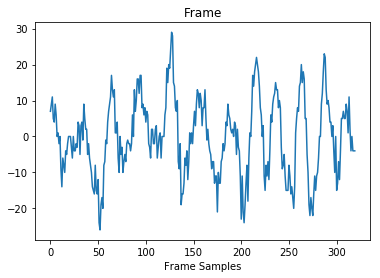

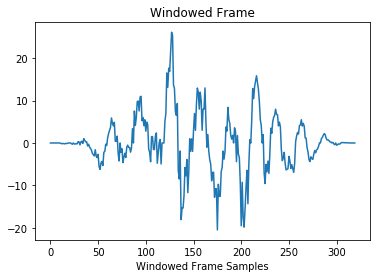

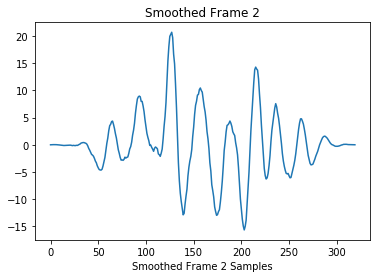

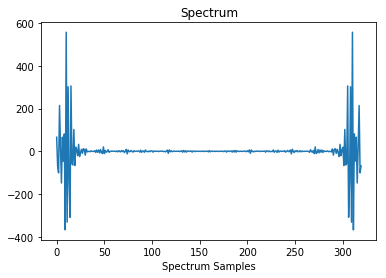

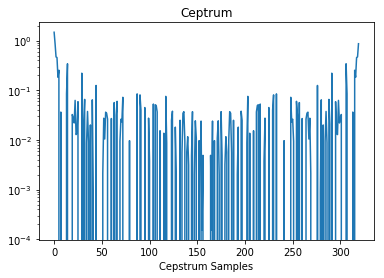

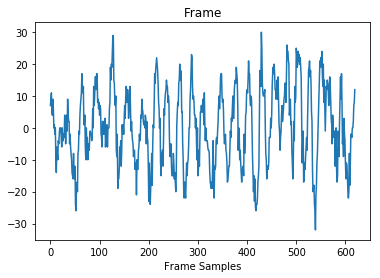

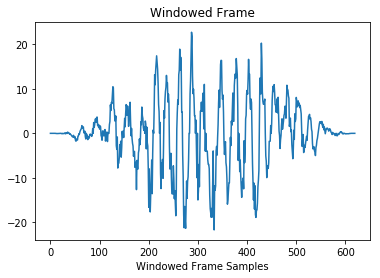

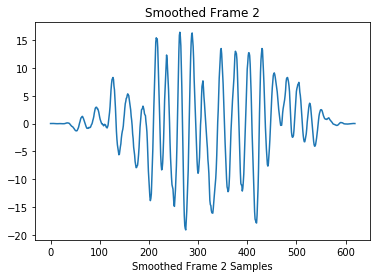

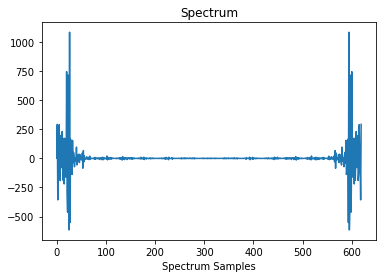

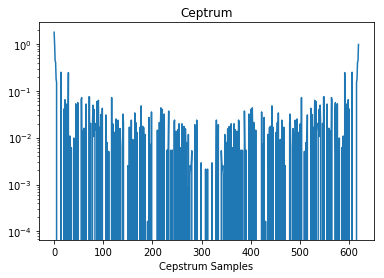

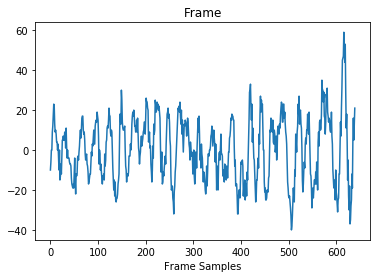

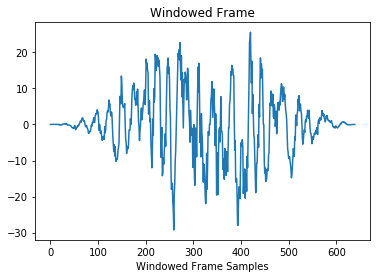

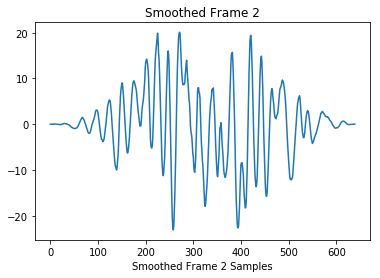

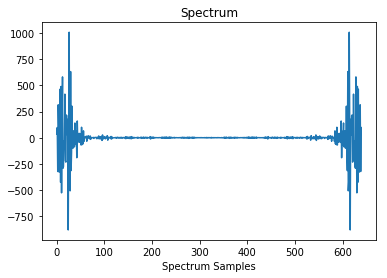

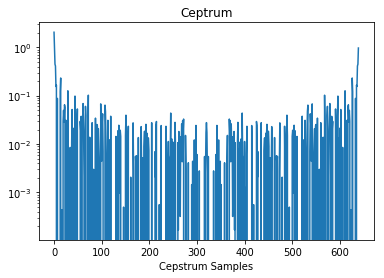

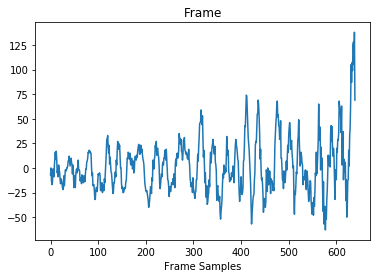

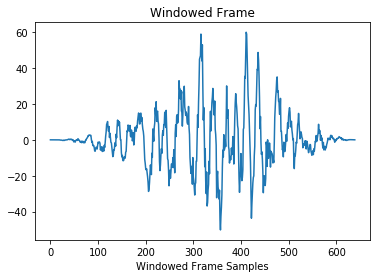

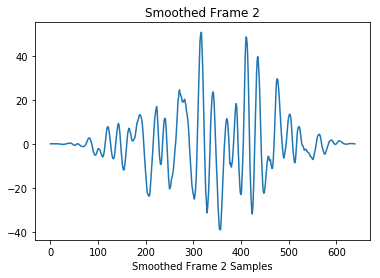

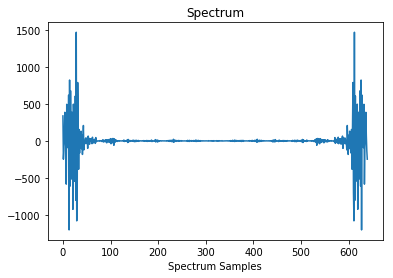

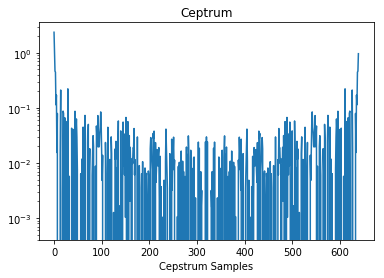

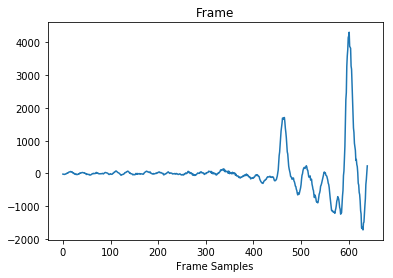

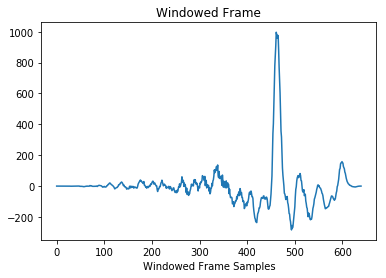

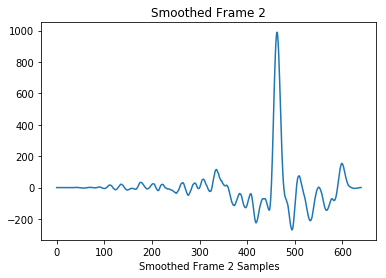

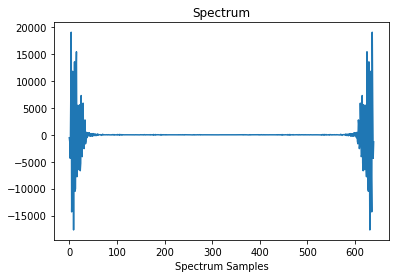

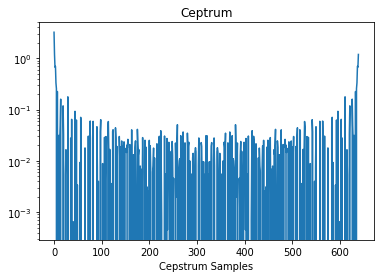

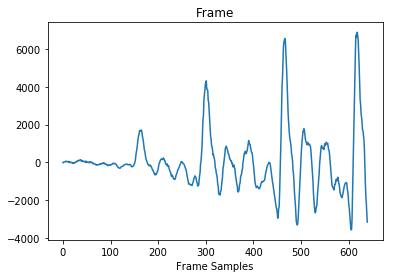

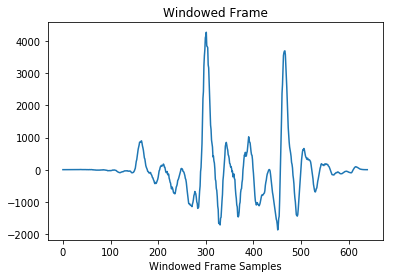

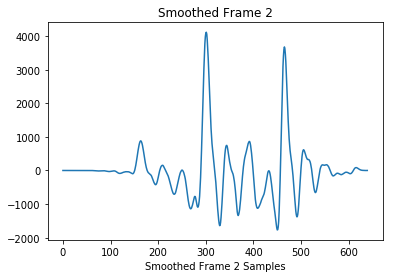

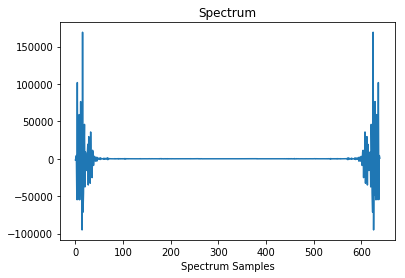

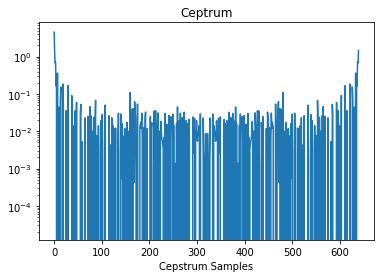

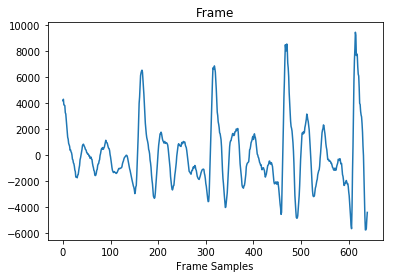

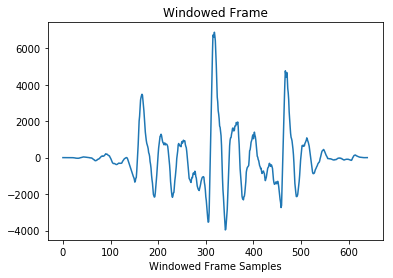

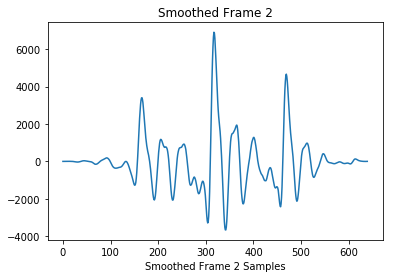

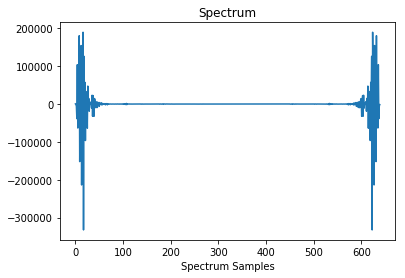

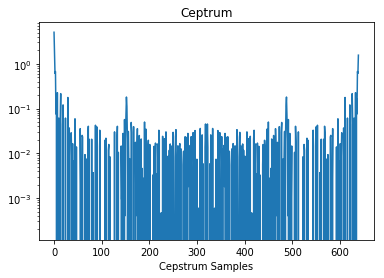

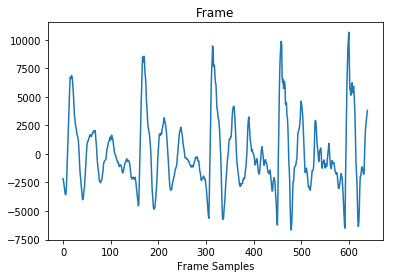

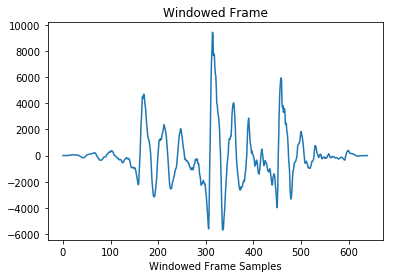

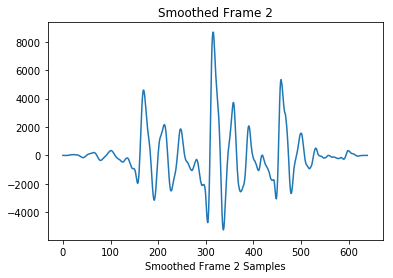

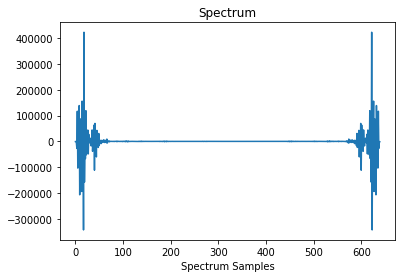

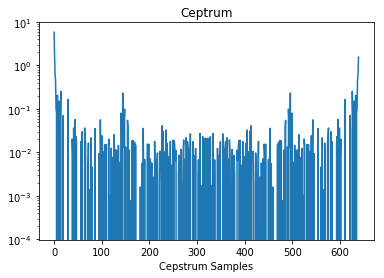

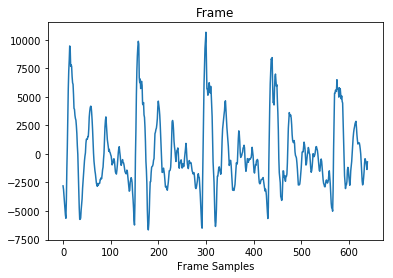

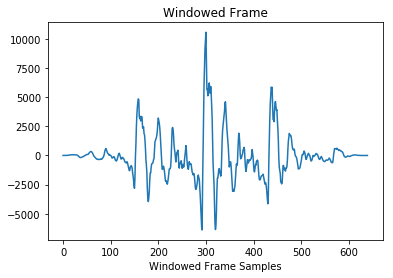

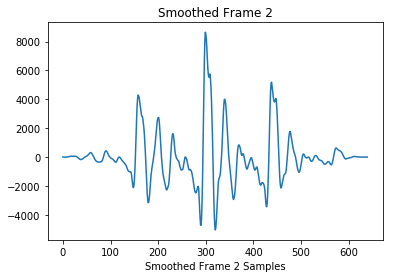

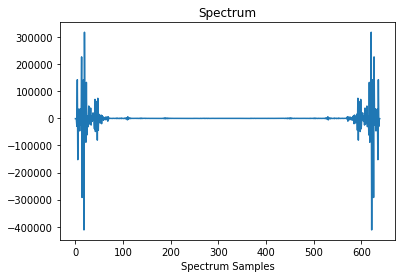

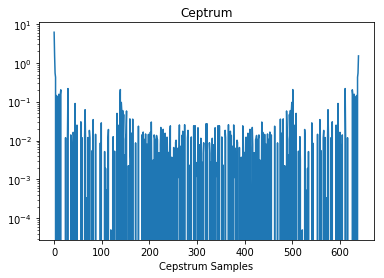

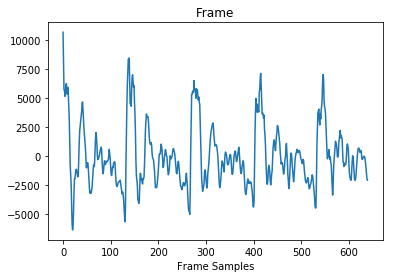

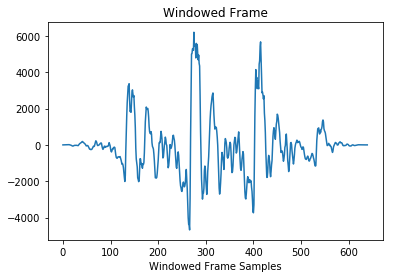

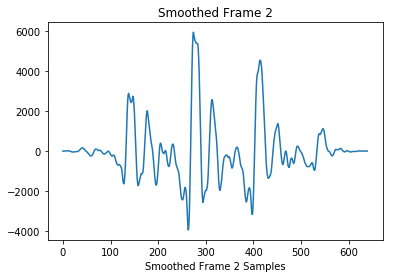

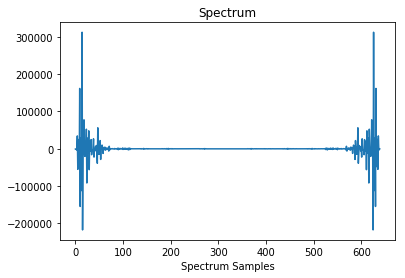

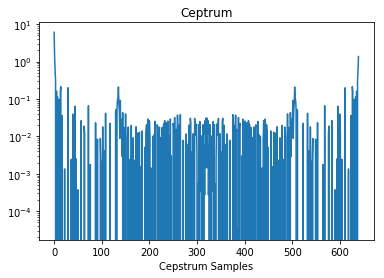

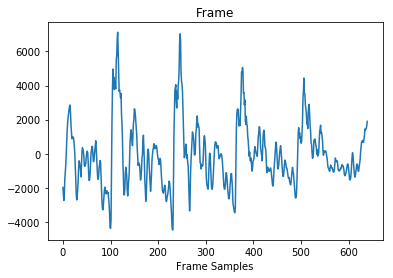

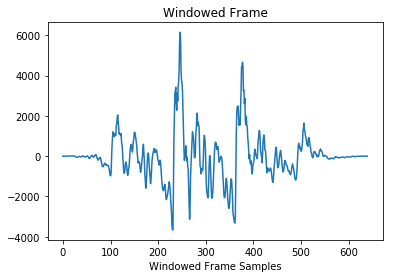

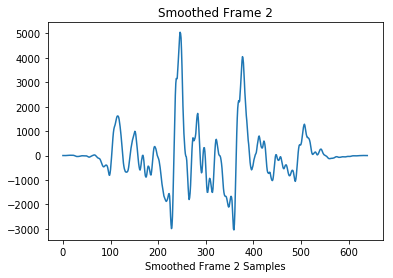

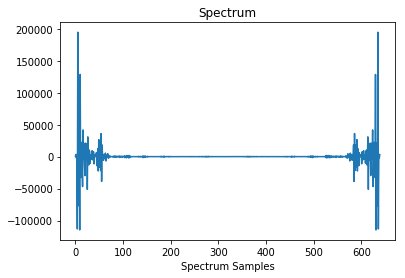

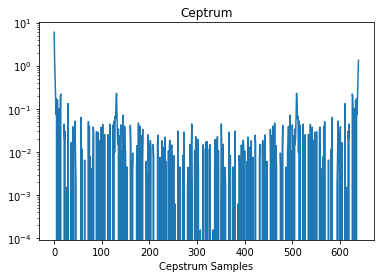

In [79]:
start_time = time.time()
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=15, left_padding=16, right_padding=16, datadir='data', submission=None)
wav2f0_file(fda_ue_options, 'data/fda_ue/rl001.wav')
print(f'Required time: {time.time() - start_time}')

# Dataset Validation and Test

In [20]:
def wav2f0(options, gui):
    fs = open(options.submission, 'w') if options.submission is not None else None
    totalCounters = Counters()
    with open(gui) as f:
        if fs is not None:
            print('id,frequency', file=fs)
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            filename = os.path.join(options.datadir, line + ".wav")
            f0ref_filename = os.path.join(options.datadir, line + ".f0ref")
            # print("Processing:", filename)
            sfreq, data = wavfile.read(filename)
            nsamples = len(data)

            # From miliseconds to samples
            ns_windowlength = int(round((options.windowlength * sfreq) / 1000))
            ns_frameshift = int(round((options.frameshift * sfreq) / 1000))
            ns_left_padding = int(round((options.left_padding * sfreq) / 1000))
            ns_right_padding = int(round((options.right_padding * sfreq) / 1000))
            pitch = []
            for id, ini in enumerate(range(-ns_left_padding, nsamples - ns_windowlength + ns_right_padding + 1, ns_frameshift)):
                first_sample = max(0, ini)
                last_sample = min(nsamples, ini + ns_windowlength)
                frame = data[first_sample:last_sample]
                
                # Apply a Hanning window to the frame
                # window = sg.windows.hann(len(frame))
                # frame = frame*window
                
                # low pass filter
                pi = 3.14
                sfreq_rad = sfreq * 2 * pi
                cutoff = 600 #Hz
                cutoff_rad = cutoff * 2 * pi
                nyq = 0.5 * sfreq_rad
                normalCutoff = cutoff_rad / nyq
                order = 30
                b, a = sg.butter(order, normalCutoff, btype='low', analog = True)
                frame = sg.lfilter(b, a, frame)
                
                # Smoothing filter
                std = 16
                frame = scipy.ndimage.gaussian_filter1d(frame, std)
                
                f0 = cepstrum_method(frame, sfreq, threshold=0.55)
                if fs is not None:
                    print(line + '_' + str(id) + ',', f0, file=fs)
                pitch.append(f0)
            
            # Apply median filter to pitch array
            pitch = sg.medfilt(volume=pitch, kernel_size=3)

            if os.path.isfile(f0ref_filename):
                counters = compare(f0ref_filename, pitch)
                totalCounters.add(counters)

    if totalCounters.num_voiced + totalCounters.num_unvoiced > 0:
        print(f"### Summary")
        print(totalCounters)
        print("-------------------------------\n")

In [ ]:
start_time = time.time()
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=15, left_padding=16, right_padding=16, datadir='data', submission=None)
wav2f0(fda_ue_options, 'data/pitch/fda_ue.gui')
print(f'Required time: {time.time() - start_time}')

In [ ]:
start_time = time.time()
fda_ue_options = SimpleNamespace(
    windowlength=32, frameshift=10, left_padding=0, right_padding=0, datadir='data', submission=None)
wav2f0(fda_ue_options, 'data/pitch/ptdb_tug.gui')
print(f'Required time: {time.time() - start_time}')

In [ ]:
test_options = SimpleNamespace(
    windowlength=26.5, frameshift=10, left_padding=13.25, right_padding=7, datadir='data/pitch/test', submission='autocorrelation_method_with_pre_post_processing_submission.csv')
wav2f0(test_options, 'data/pitch/test.gui')